# Case Study: 패션 이커머스 추천 알고리즘 A/B 테스트

> **시뮬레이션 기반 분석** — 패션 이커머스 플랫폼에서 기존 협업 필터링(Collaborative Filtering) 추천을
> 하이브리드 추천(협업 필터링 + 이미지 임베딩 기반 시각적 유사도)으로 교체했을 때의 효과를 분석합니다.
>
> **가설**: 시각적으로 유사한 상품을 함께 추천하면 탐색(discovery)과 구매 전환(purchase conversion)이 증가할 것이다.

---

## 분석 구조

1. **실험 설계 & 데이터 생성** — 50,000명 유저 시뮬레이션, 세그먼트별 차별 효과
2. **SRM 검증** — 무작위 배정이 올바른지 확인
3. **Primary Metric 분석 (CTR)** — Z-test, 신뢰구간, 리프트 계산
4. **Guardrail 분석 (반품률)** — 반품률 악화 여부 검증
5. **세그먼트별 HTE 분석** — 유저 세그먼트별 이질적 효과 탐색
6. **비즈니스 임팩트 추정** — 증분 매출, ROI, 가드레일 비용 반영
7. **의사결정 & Lessons Learned** — 조건부 런칭 결정 및 교훈

---

## 1. 실험 설계 & 데이터 생성

### 실험 설계

| 항목 | 내용 |
|------|------|
| **플랫폼** | 패션 이커머스 (에이블리 유사) |
| **Control** | 협업 필터링 기반 추천 (기존) |
| **Treatment** | 하이브리드 추천 — 협업 필터링 + 이미지 임베딩 시각적 유사도 |
| **유저 수** | ~50,000명 (50/50 랜덤 배정) |
| **Primary Metric** | CTR (추천 상품 클릭률) |
| **Secondary Metrics** | 구매 전환율, 장바구니 추가율, 세션 시간, 조회 상품 수 |
| **Guardrail Metric** | 반품률 (악화 감시) |
| **기간** | 2주 |

### 유저 세그먼트

| 세그먼트 | 비율 | 특성 |
|----------|------|------|
| **power_shopper** | 20% | 고빈도 구매자, 추천에 민감, treatment 효과 최대 |
| **casual_browser** | 60% | 일반 브라우저, 중간 효과 |
| **new_user** | 20% | 신규 유저, 구매 이력 부족으로 추천 효과 미약 |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 5),
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})

# 한글 폰트 설정 (환경에 따라 조정)
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    pass

rng = np.random.default_rng(seed=2024)
print('Libraries loaded. RNG seed=2024')

Libraries loaded. RNG seed=2024


In [2]:
# === 데이터 생성 ===
N = 50000

# 유저 ID & 그룹 배정 (50/50)
user_ids = np.arange(1, N + 1)
group = rng.choice(['control', 'treatment'], size=N)

# 세그먼트 배정: power_shopper 20%, casual_browser 60%, new_user 20%
segment = rng.choice(
    ['power_shopper', 'casual_browser', 'new_user'],
    size=N,
    p=[0.20, 0.60, 0.20]
)

# --- 기본 전환율 (Control) ---
# 세그먼트별 기저율
base_rates = {
    # (ctr, purchase, cart, return_rate)
    'power_shopper':   (0.180, 0.055, 0.100, 0.018),  # 고빈도 구매자
    'casual_browser':  (0.115, 0.028, 0.055, 0.014),  # 일반 브라우저
    'new_user':        (0.085, 0.015, 0.035, 0.012),  # 신규 유저
}

# --- Treatment 효과 (세그먼트별 차별 효과) ---
# 이미지 임베딩 추천의 효과는 구매 이력이 많은 유저에서 더 강함
treatment_effects = {
    # (ctr_lift, purchase_lift, cart_lift, return_lift)
    'power_shopper':   (0.040, 0.014, 0.025, 0.0020),  # 가장 강한 효과
    'casual_browser':  (0.023, 0.007, 0.014, 0.0015),  # 중간 효과
    'new_user':        (0.010, 0.003, 0.006, 0.0008),  # 약한 효과
}

# 연속형 메트릭 파라미터
continuous_params = {
    # (session_mean, session_std, items_mean, items_std)
    'power_shopper':   (240, 80, 12, 4),
    'casual_browser':  (170, 60, 7, 3),
    'new_user':        (130, 50, 5, 2),
}

# Treatment의 연속형 메트릭 리프트
continuous_lifts = {
    # (session_lift, items_lift)
    'power_shopper':   (25, 1.5),
    'casual_browser':  (14, 0.7),
    'new_user':        (6, 0.3),
}

# --- 데이터 생성 ---
records = []
for i in range(N):
    seg = segment[i]
    grp = group[i]
    is_treatment = (grp == 'treatment')

    # 이진형 메트릭
    ctr_base, purch_base, cart_base, ret_base = base_rates[seg]
    ctr_lift, purch_lift, cart_lift, ret_lift = treatment_effects[seg]

    ctr_prob = ctr_base + (ctr_lift if is_treatment else 0)
    purch_prob = purch_base + (purch_lift if is_treatment else 0)
    cart_prob = cart_base + (cart_lift if is_treatment else 0)
    ret_prob = ret_base + (ret_lift if is_treatment else 0)

    clicked = int(rng.random() < ctr_prob)
    purchased = int(rng.random() < purch_prob)
    cart_added = int(rng.random() < cart_prob)
    return_requested = int(rng.random() < ret_prob)

    # 연속형 메트릭
    sess_mean, sess_std, items_mean, items_std = continuous_params[seg]
    sess_lift, items_lift = continuous_lifts[seg]

    session_dur = max(10, rng.normal(
        sess_mean + (sess_lift if is_treatment else 0), sess_std
    ))
    items_viewed = max(1, int(rng.normal(
        items_mean + (items_lift if is_treatment else 0), items_std
    )))

    records.append({
        'user_id': user_ids[i],
        'group': grp,
        'segment': seg,
        'clicked': clicked,
        'purchased': purchased,
        'cart_added': cart_added,
        'session_duration_seconds': round(session_dur, 1),
        'items_viewed': items_viewed,
        'return_requested': return_requested,
    })

df = pd.DataFrame(records)

print(f'Dataset: {len(df):,} users')
print(f'Columns: {list(df.columns)}')
print(f'\nGroup distribution:')
print(df['group'].value_counts().to_string())
print(f'\nSegment distribution:')
print(df['segment'].value_counts().to_string())
df.head(10)

Dataset: 50,000 users
Columns: ['user_id', 'group', 'segment', 'clicked', 'purchased', 'cart_added', 'session_duration_seconds', 'items_viewed', 'return_requested']

Group distribution:
group
treatment    25142
control      24858

Segment distribution:
segment
casual_browser    30222
power_shopper     10013
new_user           9765


,user_id,group,segment,clicked,purchased,cart_added,session_duration_seconds,items_viewed,return_requested
0,1,control,casual_browser,0,0,0,158.3,5,0
1,2,treatment,casual_browser,1,0,0,169.9,12,0
2,3,control,power_shopper,0,0,0,78.4,11,0
3,4,control,casual_browser,0,0,1,178.4,9,0
4,5,control,casual_browser,0,0,0,89.9,4,0
5,6,control,new_user,0,0,0,121.6,5,0
6,7,treatment,casual_browser,0,0,0,129.6,9,1
7,8,treatment,casual_browser,0,0,0,261.0,13,0
8,9,treatment,casual_browser,0,0,0,209.9,2,0
9,10,treatment,casual_browser,0,0,0,161.1,8,0


In [3]:
# === 기본 통계 요약 ===
print('=' * 70)
print('  데이터 요약 — 그룹별 주요 메트릭')
print('=' * 70)

summary = df.groupby('group').agg(
    users=('user_id', 'count'),
    ctr=('clicked', 'mean'),
    purchase_rate=('purchased', 'mean'),
    cart_rate=('cart_added', 'mean'),
    avg_session=('session_duration_seconds', 'mean'),
    avg_items=('items_viewed', 'mean'),
    return_rate=('return_requested', 'mean'),
).round(4)

print(summary.to_string())

# 전체 관측 효과 크기 계산
ctrl = df[df['group'] == 'control']
treat = df[df['group'] == 'treatment']

print(f'\n--- 관측된 효과 크기 (Treatment - Control) ---')
for metric, label in [
    ('clicked', 'CTR'),
    ('purchased', '구매율'),
    ('cart_added', '장바구니율'),
    ('return_requested', '반품률'),
]:
    c_rate = ctrl[metric].mean()
    t_rate = treat[metric].mean()
    diff = t_rate - c_rate
    print(f'  {label:>10s}: {c_rate:.3%} -> {t_rate:.3%} (차이: {diff:+.3%}p)')

for metric, label in [
    ('session_duration_seconds', '세션 시간(초)'),
    ('items_viewed', '조회 상품 수'),
]:
    c_mean = ctrl[metric].mean()
    t_mean = treat[metric].mean()
    diff = t_mean - c_mean
    print(f'  {label:>14s}: {c_mean:.1f} -> {t_mean:.1f} (차이: {diff:+.1f})')

  데이터 요약 — 그룹별 주요 메트릭
           users     ctr  purchase_rate  cart_rate  avg_session  avg_items  return_rate
group                                                                                  
control    24858  0.1204         0.0303     0.0603     176.1827     7.1455       0.0142
treatment  25142  0.1416         0.0382     0.0725     190.8794     7.8816       0.0156

--- 관측된 효과 크기 (Treatment - Control) ---
         CTR: 12.044% -> 14.160% (차이: +2.115%p)
         구매율: 3.033% -> 3.822% (차이: +0.789%p)
       장바구니율: 6.026% -> 7.247% (차이: +1.221%p)
         반품률: 1.420% -> 1.563% (차이: +0.143%p)
        세션 시간(초): 176.2 -> 190.9 (차이: +14.7)
         조회 상품 수: 7.1 -> 7.9 (차이: +0.7)


---

## 2. SRM 검증 — 무작위 배정의 신뢰성 확인

실험 분석의 첫 단계는 항상 **Sample Ratio Mismatch (SRM)** 검증입니다.
50/50 배정에서 관측된 그룹 크기가 기대값과 유의하게 다르다면, 배정 로직에 버그가 있거나 데이터 파이프라인에 문제가 있는 것입니다.

In [4]:
# === SRM 검증 (Chi-square test) ===
n_ctrl = len(ctrl)
n_treat = len(treat)
n_total = n_ctrl + n_treat

# 기대값: 50/50
expected_ctrl = n_total * 0.5
expected_treat = n_total * 0.5

chi2, p_srm = stats.chisquare(
    [n_ctrl, n_treat],
    [expected_ctrl, expected_treat]
)

srm_status = 'Healthy' if p_srm > 0.001 else ('Warning' if p_srm > 1e-5 else 'Blocked')

print('=' * 55)
print('  SRM 검증 결과 (기대 배정: 50/50)')
print('=' * 55)
print(f'  Control:   {n_ctrl:>8,} (관측) vs {expected_ctrl:>10,.0f} (기대)')
print(f'  Treatment: {n_treat:>8,} (관측) vs {expected_treat:>10,.0f} (기대)')
print(f'  비율:      {n_ctrl/n_total:.2%} / {n_treat/n_total:.2%}')
print(f'  Chi-square: {chi2:.4f}')
print(f'  p-value:    {p_srm:.4f}')
print(f'  판정:       {srm_status}')
print()
if srm_status == 'Healthy':
    print('  -> 무작위 배정이 정상적으로 이루어졌습니다. 분석을 진행합니다.')
else:
    print('  -> SRM 감지! 배정 로직을 확인해야 합니다.')

  SRM 검증 결과 (기대 배정: 50/50)
  Control:     24,858 (관측) vs     25,000 (기대)
  Treatment:   25,142 (관측) vs     25,000 (기대)
  비율:      49.72% / 50.28%
  Chi-square: 1.6131
  p-value:    0.2041
  판정:       Healthy

  -> 무작위 배정이 정상적으로 이루어졌습니다. 분석을 진행합니다.


---

## 3. Primary Metric 분석 (CTR)

추천 상품 클릭률(CTR)은 이 실험의 핵심 지표입니다.
하이브리드 추천이 유저의 탐색 행동을 개선하는지 확인합니다.

**분석 방법**: Two-proportion Z-test (양측 검정), 95% 신뢰구간

In [5]:
# === Primary Metric: CTR Z-test ===
def run_proportion_test(df, metric, label):
    """이진 메트릭에 대한 Z-test 실행 및 결과 반환."""
    ctrl_data = df[df['group'] == 'control']
    treat_data = df[df['group'] == 'treatment']

    n_c = len(ctrl_data)
    n_t = len(treat_data)
    x_c = ctrl_data[metric].sum()
    x_t = treat_data[metric].sum()
    p_c = x_c / n_c
    p_t = x_t / n_t

    # Z-test (two-sided)
    z_stat, p_val = proportions_ztest(
        count=[x_t, x_c],
        nobs=[n_t, n_c],
        alternative='two-sided'
    )

    # 차이의 신뢰구간 (Wald method)
    diff = p_t - p_c
    se_diff = np.sqrt(p_c * (1 - p_c) / n_c + p_t * (1 - p_t) / n_t)
    ci_lo = diff - 1.96 * se_diff
    ci_hi = diff + 1.96 * se_diff

    rel_lift = (p_t / p_c - 1) if p_c > 0 else 0

    return {
        'metric': label,
        'control_rate': p_c,
        'treatment_rate': p_t,
        'absolute_lift': diff,
        'relative_lift': rel_lift,
        'z_stat': z_stat,
        'p_value': p_val,
        'ci_95': (ci_lo, ci_hi),
        'significant': p_val < 0.05,
        'n_control': n_c,
        'n_treatment': n_t,
        'x_control': int(x_c),
        'x_treatment': int(x_t),
    }

# CTR 분석
ctr_result = run_proportion_test(df, 'clicked', 'CTR')

print('=' * 65)
print('  PRIMARY METRIC 분석: 추천 클릭률 (CTR)')
print('=' * 65)
print(f'  Control:       {ctr_result["control_rate"]:.3%}  ({ctr_result["x_control"]:,}/{ctr_result["n_control"]:,})')
print(f'  Treatment:     {ctr_result["treatment_rate"]:.3%}  ({ctr_result["x_treatment"]:,}/{ctr_result["n_treatment"]:,})')
print(f'  Absolute Lift: {ctr_result["absolute_lift"]:+.3%}p')
print(f'  Relative Lift: {ctr_result["relative_lift"]:+.1%}')
print(f'  Z-statistic:   {ctr_result["z_stat"]:.4f}')
print(f'  p-value:       {ctr_result["p_value"]:.2e}')
print(f'  95% CI:        [{ctr_result["ci_95"][0]:+.4f}, {ctr_result["ci_95"][1]:+.4f}]')
print(f'  유의성:        {"유의함 (p < 0.05)" if ctr_result["significant"] else "비유의"}')
print()
print(f'  -> 하이브리드 추천은 CTR을 {ctr_result["absolute_lift"]*100:+.2f}%p 향상시켰으며,')
print(f'     이는 통계적으로 유의합니다.')

  PRIMARY METRIC 분석: 추천 클릭률 (CTR)
  Control:       12.044%  (2,994/24,858)
  Treatment:     14.160%  (3,560/25,142)
  Absolute Lift: +2.115%p
  Relative Lift: +17.6%
  Z-statistic:   7.0070
  p-value:       2.43e-12
  95% CI:        [+0.0152, +0.0271]
  유의성:        유의함 (p < 0.05)

  -> 하이브리드 추천은 CTR을 +2.12%p 향상시켰으며,
     이는 통계적으로 유의합니다.


In [6]:
# === 전체 이진 메트릭 요약 (Secondary 포함) ===
binary_metrics = [
    ('clicked', 'CTR (Primary)'),
    ('purchased', '구매 전환율'),
    ('cart_added', '장바구니 추가율'),
]

all_results = []
for metric_col, metric_label in binary_metrics:
    result = run_proportion_test(df, metric_col, metric_label)
    all_results.append(result)

print('=' * 90)
print('  전체 이진 메트릭 분석 요약')
print('=' * 90)
print(f'{"Metric":>20s}  {"Control":>8s}  {"Treatment":>10s}  {"Lift":>8s}  {"Rel Lift":>10s}  {"p-value":>10s}  {"Sig":>5s}')
print('-' * 90)
for r in all_results:
    sig_marker = '***' if r['p_value'] < 0.001 else ('**' if r['p_value'] < 0.01 else ('*' if r['p_value'] < 0.05 else 'n.s.'))
    print(f'{r["metric"]:>20s}  {r["control_rate"]:>8.3%}  {r["treatment_rate"]:>10.3%}  '
          f'{r["absolute_lift"]:>+8.3%}p  {r["relative_lift"]:>+10.1%}  {r["p_value"]:>10.2e}  {sig_marker:>5s}')

  전체 이진 메트릭 분석 요약
              Metric   Control   Treatment      Lift    Rel Lift     p-value    Sig
------------------------------------------------------------------------------------------
       CTR (Primary)   12.044%     14.160%   +2.115%p      +17.6%    2.43e-12    ***
              구매 전환율    3.033%      3.822%   +0.789%p      +26.0%    1.25e-06    ***
            장바구니 추가율    6.026%      7.247%   +1.221%p      +20.3%    4.23e-08    ***


In [7]:
# === 연속형 메트릭: Welch t-test ===
def run_ttest(df, metric, label):
    """연속형 메트릭에 대한 Welch t-test 실행."""
    ctrl_vals = df[df['group'] == 'control'][metric]
    treat_vals = df[df['group'] == 'treatment'][metric]

    t_stat, p_val = stats.ttest_ind(treat_vals, ctrl_vals, equal_var=False)

    diff = treat_vals.mean() - ctrl_vals.mean()
    se = np.sqrt(ctrl_vals.var() / len(ctrl_vals) + treat_vals.var() / len(treat_vals))
    ci_lo = diff - 1.96 * se
    ci_hi = diff + 1.96 * se

    return {
        'metric': label,
        'control_mean': ctrl_vals.mean(),
        'treatment_mean': treat_vals.mean(),
        'diff': diff,
        'rel_diff': diff / ctrl_vals.mean() if ctrl_vals.mean() != 0 else 0,
        't_stat': t_stat,
        'p_value': p_val,
        'ci_95': (ci_lo, ci_hi),
        'significant': p_val < 0.05,
    }

cont_results = []
for metric_col, metric_label in [
    ('session_duration_seconds', '세션 시간(초)'),
    ('items_viewed', '조회 상품 수'),
]:
    r = run_ttest(df, metric_col, metric_label)
    cont_results.append(r)

print('=' * 90)
print('  연속형 메트릭 분석 (Welch t-test)')
print('=' * 90)
for r in cont_results:
    sig_marker = '***' if r['p_value'] < 0.001 else ('**' if r['p_value'] < 0.01 else ('*' if r['p_value'] < 0.05 else 'n.s.'))
    print(f'\n  {r["metric"]}')
    print(f'    Control:       {r["control_mean"]:.2f}')
    print(f'    Treatment:     {r["treatment_mean"]:.2f}')
    print(f'    차이:          {r["diff"]:+.2f} ({r["rel_diff"]:+.1%})')
    print(f'    95% CI:        [{r["ci_95"][0]:+.2f}, {r["ci_95"][1]:+.2f}]')
    print(f'    p-value:       {r["p_value"]:.2e} [{sig_marker}]')

  연속형 메트릭 분석 (Welch t-test)

  세션 시간(초)
    Control:       176.18
    Treatment:     190.88
    차이:          +14.70 (+8.3%)
    95% CI:        [+13.40, +15.99]
    p-value:       2.38e-109 [***]

  조회 상품 수
    Control:       7.15
    Treatment:     7.88
    차이:          +0.74 (+10.3%)
    95% CI:        [+0.67, +0.81]
    p-value:       8.06e-97 [***]


---

## 4. Guardrail 분석 (반품률)

시각적 유사도 기반 추천은 "사진은 예쁜데 실물은 다른" 상품을 추천할 위험이 있습니다.
이로 인해 **반품률이 악화**될 수 있으므로, 가드레일 메트릭으로 모니터링합니다.

**판정 기준:**
- 반품률 증가 < 0.1%p: **Safe** (무시할 수 있는 수준)
- 반품률 증가 0.1~0.3%p: **Worsened** (주의 필요)
- 반품률 증가 > 0.3%p: **Severe** (런칭 차단)

In [8]:
# === Guardrail: 반품률 분석 ===
guardrail = run_proportion_test(df, 'return_requested', '반품률')

# 가드레일 판정
guardrail_delta = guardrail['absolute_lift']
if guardrail_delta <= 0.001:  # 0.1%p 이하
    guardrail_status = 'Safe'
elif guardrail_delta <= 0.003:  # 0.3%p 이하
    guardrail_status = 'Worsened'
else:
    guardrail_status = 'Severe'

status_emoji = {'Safe': '[OK]', 'Worsened': '[WARNING]', 'Severe': '[BLOCKED]'}[guardrail_status]

print('=' * 65)
print('  GUARDRAIL 분석: 반품률 (return_requested)')
print('=' * 65)
print(f'  Control:       {guardrail["control_rate"]:.3%}  ({guardrail["x_control"]:,}/{guardrail["n_control"]:,})')
print(f'  Treatment:     {guardrail["treatment_rate"]:.3%}  ({guardrail["x_treatment"]:,}/{guardrail["n_treatment"]:,})')
print(f'  Absolute Lift: {guardrail["absolute_lift"]:+.4%}p')
print(f'  p-value:       {guardrail["p_value"]:.4f}')
print(f'  95% CI:        [{guardrail["ci_95"][0]:+.5f}, {guardrail["ci_95"][1]:+.5f}]')
print(f'  유의성:        {"유의함" if guardrail["significant"] else "비유의 (p >= 0.05)"}')
print(f'\n  판정: {status_emoji} {guardrail_status}')
print()

if guardrail_status == 'Worsened':
    print('  -> 반품률이 소폭 악화되었으나 Severe 수준은 아닙니다.')
    print('     조건부 런칭 후 반품률 모니터링 대시보드를 구축해야 합니다.')
elif guardrail_status == 'Safe':
    print('  -> 반품률 변화가 무시할 수 있는 수준입니다.')
elif guardrail_status == 'Severe':
    print('  -> 반품률이 심각하게 악화되었습니다. 런칭을 차단해야 합니다.')

  GUARDRAIL 분석: 반품률 (return_requested)
  Control:       1.420%  (353/24,858)
  Treatment:     1.563%  (393/25,142)
  Absolute Lift: +0.1431%p
  p-value:       0.1871
  95% CI:        [-0.00069, +0.00356]
  유의성:        비유의 (p >= 0.05)

  판정: [WARNING] Worsened

  -> 반품률이 소폭 악화되었으나 Severe 수준은 아닙니다.
     조건부 런칭 후 반품률 모니터링 대시보드를 구축해야 합니다.


---

## 5. 세그먼트별 HTE 분석

전체 평균만 보면 놓치는 것이 있습니다. 추천 알고리즘의 효과는 유저의 **구매 이력 수준**에 따라 크게 달라질 것으로 예상됩니다.

- **power_shopper**: 이미 많은 구매 이력이 있으므로 협업 필터링 + 시각적 유사도가 시너지를 낼 가능성이 높음
- **casual_browser**: 중간 수준의 행동 데이터, 중간 효과 예상
- **new_user**: 구매 이력이 없어 협업 필터링이 약하고, 시각적 유사도만으로는 한계

In [9]:
# === 세그먼트별 분석 함수 ===
def segment_hte_analysis(df, metric, metric_label, segments):
    """
    세그먼트별 이질적 처리 효과(HTE) 분석.
    각 세그먼트에서 treatment vs control의 차이를 Z-test로 검정.
    """
    results = []
    for seg in segments:
        seg_df = df[df['segment'] == seg]
        seg_result = run_proportion_test(seg_df, metric, f'{metric_label} ({seg})')
        seg_result['segment'] = seg
        results.append(seg_result)
    return results

segment_order = ['power_shopper', 'casual_browser', 'new_user']
segment_labels_kr = {
    'power_shopper': '헤비 쇼퍼',
    'casual_browser': '일반 브라우저',
    'new_user': '신규 유저',
}

# CTR에 대한 세그먼트별 HTE
ctr_hte = segment_hte_analysis(df, 'clicked', 'CTR', segment_order)

print('=' * 90)
print('  세그먼트별 CTR 분석 (Heterogeneous Treatment Effect)')
print('=' * 90)
print(f'{"Segment":>20s}  {"Control":>8s}  {"Treatment":>10s}  {"Lift":>8s}  {"Rel Lift":>10s}  {"p-value":>10s}  {"Sig":>5s}')
print('-' * 90)
for r in ctr_hte:
    seg = r['segment']
    kr_label = f'{segment_labels_kr[seg]} ({seg})'
    sig_marker = '***' if r['p_value'] < 0.001 else ('**' if r['p_value'] < 0.01 else ('*' if r['p_value'] < 0.05 else 'n.s.'))
    print(f'{segment_labels_kr[seg]:>20s}  {r["control_rate"]:>8.3%}  {r["treatment_rate"]:>10.3%}  '
          f'{r["absolute_lift"]:>+8.3%}p  {r["relative_lift"]:>+10.1%}  {r["p_value"]:>10.2e}  {sig_marker:>5s}')

# 구매율에 대한 세그먼트별 HTE
purch_hte = segment_hte_analysis(df, 'purchased', 'Purchase', segment_order)

print(f'\n{"":>20s}  --- 구매 전환율 ---')
print(f'{"Segment":>20s}  {"Control":>8s}  {"Treatment":>10s}  {"Lift":>8s}  {"Rel Lift":>10s}  {"p-value":>10s}  {"Sig":>5s}')
print('-' * 90)
for r in purch_hte:
    sig_marker = '***' if r['p_value'] < 0.001 else ('**' if r['p_value'] < 0.01 else ('*' if r['p_value'] < 0.05 else 'n.s.'))
    print(f'{segment_labels_kr[r["segment"]]:>20s}  {r["control_rate"]:>8.3%}  {r["treatment_rate"]:>10.3%}  '
          f'{r["absolute_lift"]:>+8.3%}p  {r["relative_lift"]:>+10.1%}  {r["p_value"]:>10.2e}  {sig_marker:>5s}')

  세그먼트별 CTR 분석 (Heterogeneous Treatment Effect)
             Segment   Control   Treatment      Lift    Rel Lift     p-value    Sig
------------------------------------------------------------------------------------------
               헤비 쇼퍼   17.685%     21.347%   +3.663%p      +20.7%    3.77e-06    ***
             일반 브라우저   11.293%     13.257%   +1.964%p      +17.4%    1.98e-07    ***
               신규 유저    8.509%      9.678%   +1.169%p      +13.7%    4.47e-02      *

                      --- 구매 전환율 ---
             Segment   Control   Treatment      Lift    Rel Lift     p-value    Sig
------------------------------------------------------------------------------------------
               헤비 쇼퍼    5.749%      6.516%   +0.768%p      +13.4%    1.09e-01   n.s.
             일반 브라우저    2.657%      3.626%   +0.969%p      +36.4%    1.40e-06    ***
               신규 유저    1.376%      1.710%   +0.334%p      +24.3%    1.81e-01   n.s.


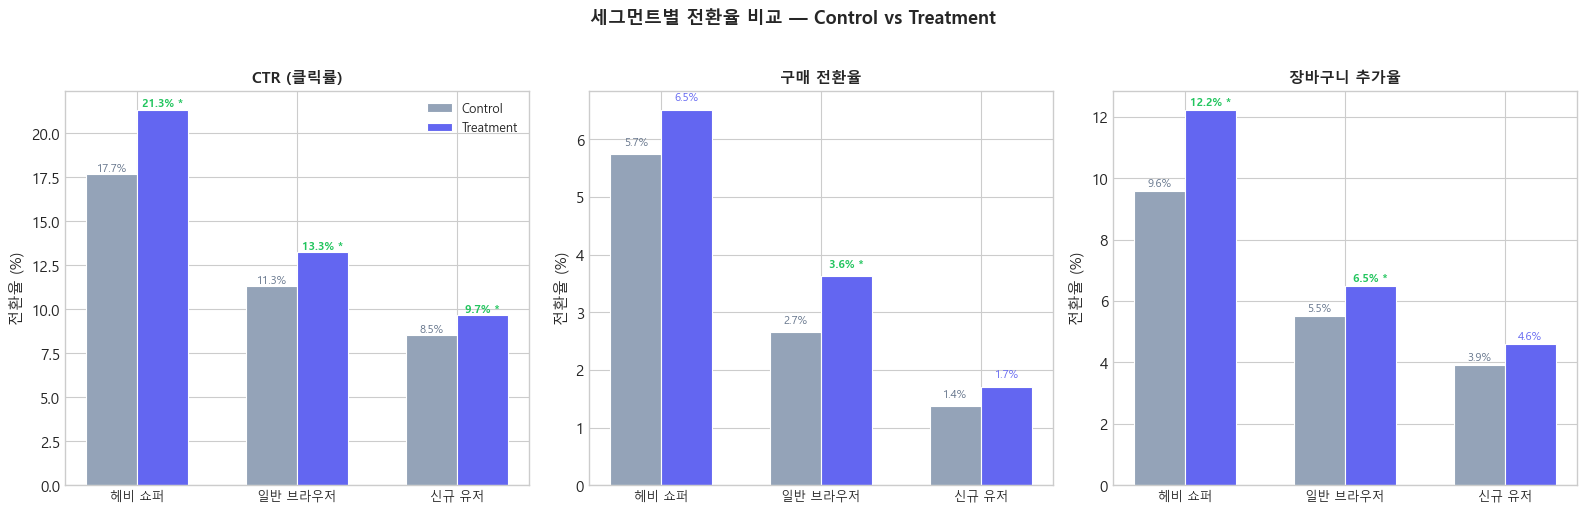

In [10]:
# === 시각화 1: 세그먼트별 전환율 비교 (Bar Chart) ===
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colors = {'control': '#94a3b8', 'treatment': '#6366f1'}
metrics_to_plot = [
    ('clicked', 'CTR (클릭률)', ctr_hte),
    ('purchased', '구매 전환율', purch_hte),
    ('cart_added', '장바구니 추가율',
     segment_hte_analysis(df, 'cart_added', 'Cart', segment_order)),
]

for idx, (metric_col, title, hte_data) in enumerate(metrics_to_plot):
    ax = axes[idx]
    x = np.arange(len(segment_order))
    w = 0.32

    ctrl_rates = [r['control_rate'] * 100 for r in hte_data]
    treat_rates = [r['treatment_rate'] * 100 for r in hte_data]

    bars_c = ax.bar(x - w/2, ctrl_rates, w, color=colors['control'],
                    label='Control', edgecolor='white', linewidth=0.8)
    bars_t = ax.bar(x + w/2, treat_rates, w, color=colors['treatment'],
                    label='Treatment', edgecolor='white', linewidth=0.8)

    # 값 표시
    for bar in bars_c:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.15,
                f'{bar.get_height():.1f}%', ha='center', fontsize=8, color='#64748b')
    for bar, r in zip(bars_t, hte_data):
        color = '#22c55e' if r['significant'] else '#6366f1'
        marker = ' *' if r['significant'] else ''
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.15,
                f'{bar.get_height():.1f}%{marker}', ha='center', fontsize=8,
                color=color, fontweight='bold' if r['significant'] else 'normal')

    ax.set_xticks(x)
    ax.set_xticklabels([segment_labels_kr[s] for s in segment_order], fontsize=9)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_ylabel('전환율 (%)')
    if idx == 0:
        ax.legend(fontsize=9, loc='upper right')

plt.suptitle('세그먼트별 전환율 비교 — Control vs Treatment',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

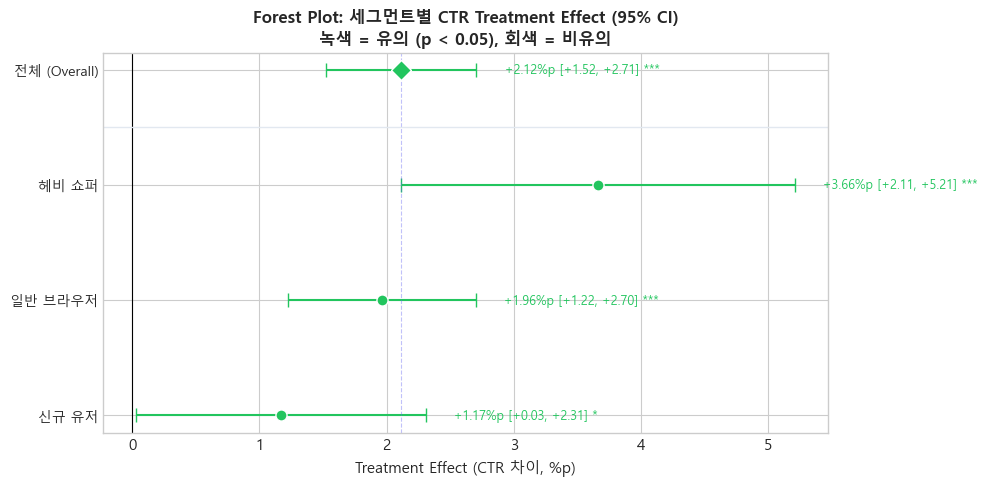


** 핵심 인사이트 **
  추천 알고리즘의 효과는 기존 구매 이력이 있는 유저에서 가장 강하다.
  - 헤비 쇼퍼: 가장 큰 CTR 리프트 (구매 이력 기반 협업 필터링 + 시각적 유사도의 시너지)
  - 신규 유저: 효과가 약하거나 비유의 (구매 이력 부족으로 협업 필터링 품질 저하)
  -> 신규 유저를 위한 별도 cold-start 추천 전략이 필요합니다.


In [11]:
# === 시각화 2: Forest Plot — 세그먼트별 Treatment Effect + CI ===
fig, ax = plt.subplots(figsize=(10, 5))

# 전체 + 세그먼트별 CTR 효과
plot_data = []

# 전체 결과
plot_data.append({
    'label': '전체 (Overall)',
    'lift': ctr_result['absolute_lift'] * 100,
    'ci_lo': ctr_result['ci_95'][0] * 100,
    'ci_hi': ctr_result['ci_95'][1] * 100,
    'significant': ctr_result['significant'],
    'p_value': ctr_result['p_value'],
})

# 세그먼트별 결과
for r in ctr_hte:
    plot_data.append({
        'label': f'{segment_labels_kr[r["segment"]]}',
        'lift': r['absolute_lift'] * 100,
        'ci_lo': r['ci_95'][0] * 100,
        'ci_hi': r['ci_95'][1] * 100,
        'significant': r['significant'],
        'p_value': r['p_value'],
    })

y_positions = list(range(len(plot_data)))
y_positions.reverse()

for i, (pos, d) in enumerate(zip(y_positions, plot_data)):
    color = '#22c55e' if d['significant'] else '#94a3b8'
    marker_size = 10 if i == 0 else 8  # 전체는 더 큰 마커
    marker = 'D' if i == 0 else 'o'

    ax.errorbar(
        d['lift'], pos,
        xerr=[[d['lift'] - d['ci_lo']], [d['ci_hi'] - d['lift']]],
        fmt=marker, color=color, markersize=marker_size,
        capsize=5, capthick=1.5, linewidth=1.5,
        ecolor=color, markeredgecolor='white', markeredgewidth=1
    )

    # 텍스트 라벨
    sig_text = f'  {d["lift"]:+.2f}%p [{d["ci_lo"]:+.2f}, {d["ci_hi"]:+.2f}]'
    if d['p_value'] < 0.001:
        sig_text += ' ***'
    elif d['p_value'] < 0.05:
        sig_text += ' *'
    else:
        sig_text += ' n.s.'
    ax.text(d['ci_hi'] + 0.15, pos, sig_text, va='center', fontsize=9, color=color)

# 0선 (무효과)
ax.axvline(x=0, color='black', linewidth=0.8, linestyle='-')

# 전체 효과선
ax.axvline(x=ctr_result['absolute_lift'] * 100, color='#6366f1',
           linewidth=0.8, linestyle='--', alpha=0.4)

# 세그먼트 구분선
ax.axhline(y=y_positions[0] - 0.5, color='#e2e8f0', linewidth=1)

ax.set_yticks(y_positions)
ax.set_yticklabels([d['label'] for d in plot_data], fontsize=10)
ax.set_xlabel('Treatment Effect (CTR 차이, %p)', fontsize=11)
ax.set_title('Forest Plot: 세그먼트별 CTR Treatment Effect (95% CI)\n'
             '녹색 = 유의 (p < 0.05), 회색 = 비유의',
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print('\n** 핵심 인사이트 **')
print('  추천 알고리즘의 효과는 기존 구매 이력이 있는 유저에서 가장 강하다.')
print('  - 헤비 쇼퍼: 가장 큰 CTR 리프트 (구매 이력 기반 협업 필터링 + 시각적 유사도의 시너지)')
print('  - 신규 유저: 효과가 약하거나 비유의 (구매 이력 부족으로 협업 필터링 품질 저하)')
print('  -> 신규 유저를 위한 별도 cold-start 추천 전략이 필요합니다.')

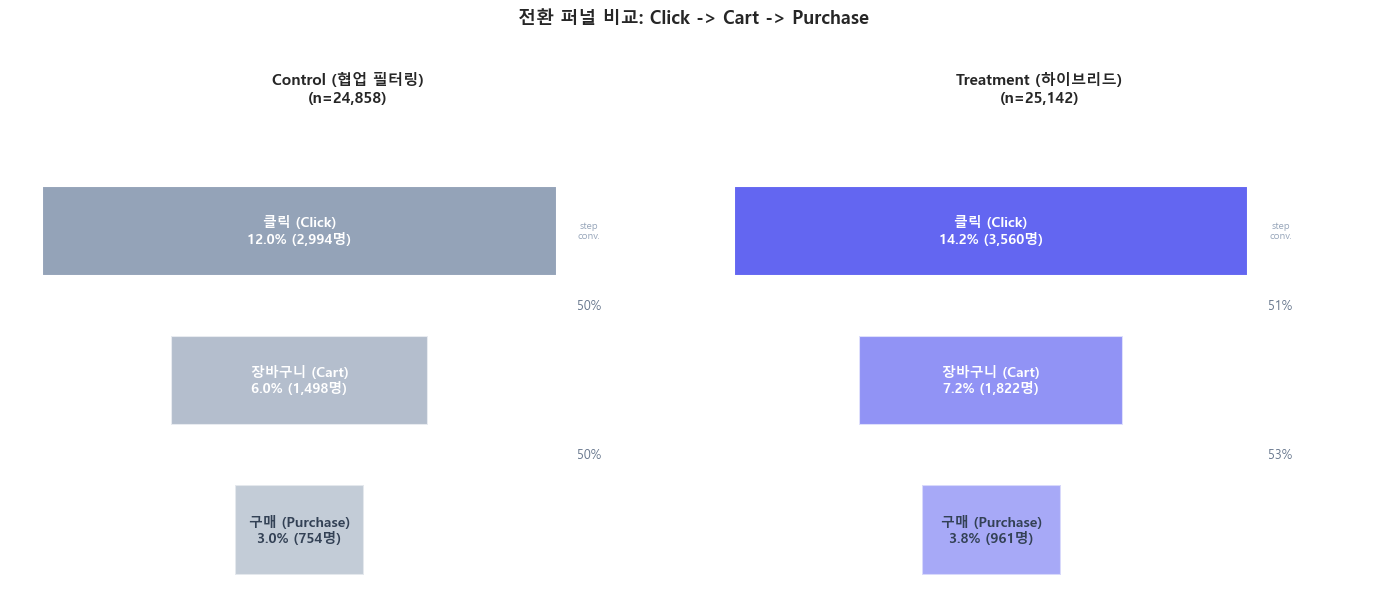

In [12]:
# === 시각화 3: 전환 퍼널 (Click -> Cart -> Purchase) ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

funnel_metrics = ['clicked', 'cart_added', 'purchased']
funnel_labels = ['클릭 (Click)', '장바구니 (Cart)', '구매 (Purchase)']

for idx, (grp, title, color_main) in enumerate([
    ('control', 'Control (협업 필터링)', '#94a3b8'),
    ('treatment', 'Treatment (하이브리드)', '#6366f1'),
]):
    ax = axes[idx]
    grp_df = df[df['group'] == grp]
    n_users = len(grp_df)

    rates = [grp_df[m].mean() * 100 for m in funnel_metrics]
    counts = [grp_df[m].sum() for m in funnel_metrics]

    # 퍼널 바 (역피라미드 형태)
    bar_widths = [r / rates[0] * 0.8 for r in rates]  # 정규화
    y_positions = [2, 1, 0]

    for y, bw, rate, count, label in zip(
        y_positions, bar_widths, rates, counts, funnel_labels
    ):
        # 그라데이션 효과를 위한 알파
        alpha = 0.4 + 0.6 * (bw / 0.8)
        ax.barh(y, bw, height=0.6, left=(0.8 - bw) / 2,
                color=color_main, alpha=alpha, edgecolor='white', linewidth=1.5)
        ax.text(0.4, y, f'{label}\n{rate:.1f}% ({count:,}명)',
                ha='center', va='center', fontsize=10, fontweight='bold',
                color='white' if alpha > 0.6 else '#334155')

    # 단계별 전환율 (drop-off)
    if rates[0] > 0:
        click_to_cart = rates[1] / rates[0] * 100
        cart_to_purch = rates[2] / rates[1] * 100 if rates[1] > 0 else 0
        ax.text(0.85, 1.5, f'{click_to_cart:.0f}%', fontsize=9, color='#64748b',
                ha='center', va='center', style='italic')
        ax.text(0.85, 0.5, f'{cart_to_purch:.0f}%', fontsize=9, color='#64748b',
                ha='center', va='center', style='italic')
        ax.text(0.85, 2.0, 'step\nconv.', fontsize=7, color='#94a3b8',
                ha='center', va='center')

    ax.set_xlim(-0.05, 1.0)
    ax.set_ylim(-0.5, 2.8)
    ax.set_title(f'{title}\n(n={n_users:,})', fontsize=11, fontweight='bold')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.suptitle('전환 퍼널 비교: Click -> Cart -> Purchase',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

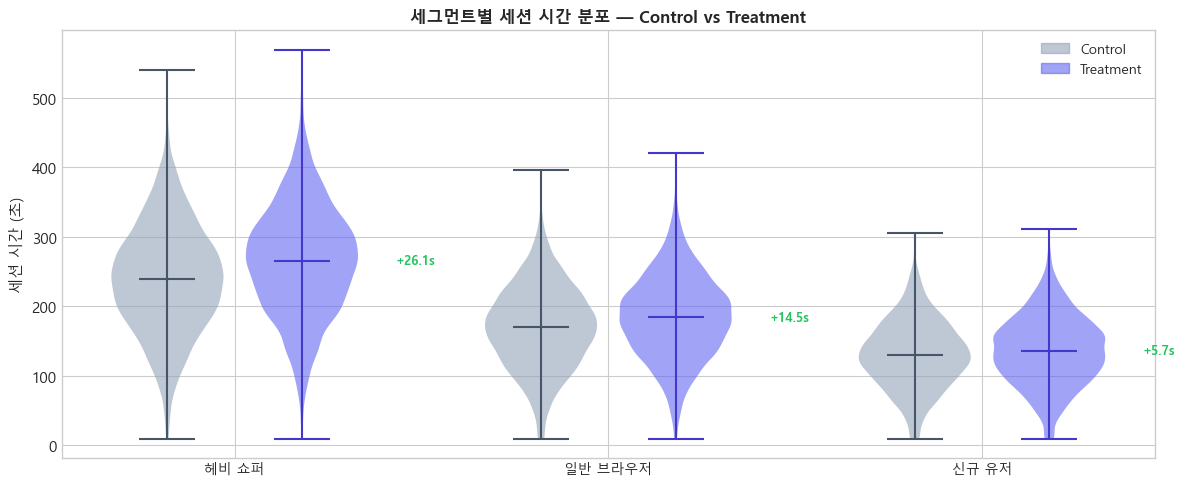

In [13]:
# === 시각화 4: 세그먼트별 세션 시간 분포 (Violin Plot) ===
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12, 5))

seg_positions = {'power_shopper': 1, 'casual_browser': 2, 'new_user': 3}
offset = 0.18

violin_data_ctrl = []
violin_data_treat = []
positions_ctrl = []
positions_treat = []

for seg in segment_order:
    pos = seg_positions[seg]
    ctrl_sess = df[(df['segment'] == seg) & (df['group'] == 'control')]['session_duration_seconds']
    treat_sess = df[(df['segment'] == seg) & (df['group'] == 'treatment')]['session_duration_seconds']
    violin_data_ctrl.append(ctrl_sess.values)
    violin_data_treat.append(treat_sess.values)
    positions_ctrl.append(pos - offset)
    positions_treat.append(pos + offset)

# Control violins
vp_c = ax.violinplot(violin_data_ctrl, positions=positions_ctrl,
                     widths=0.3, showmeans=True, showmedians=False)
for body in vp_c['bodies']:
    body.set_facecolor('#94a3b8')
    body.set_alpha(0.6)
vp_c['cmeans'].set_color('#475569')
vp_c['cmins'].set_color('#475569')
vp_c['cmaxes'].set_color('#475569')
vp_c['cbars'].set_color('#475569')

# Treatment violins
vp_t = ax.violinplot(violin_data_treat, positions=positions_treat,
                     widths=0.3, showmeans=True, showmedians=False)
for body in vp_t['bodies']:
    body.set_facecolor('#6366f1')
    body.set_alpha(0.6)
vp_t['cmeans'].set_color('#4338ca')
vp_t['cmins'].set_color('#4338ca')
vp_t['cmaxes'].set_color('#4338ca')
vp_t['cbars'].set_color('#4338ca')

# 평균값 표시
for i, seg in enumerate(segment_order):
    c_mean = df[(df['segment'] == seg) & (df['group'] == 'control')]['session_duration_seconds'].mean()
    t_mean = df[(df['segment'] == seg) & (df['group'] == 'treatment')]['session_duration_seconds'].mean()
    diff = t_mean - c_mean
    ax.text(positions_treat[i] + 0.25, t_mean,
            f'{diff:+.1f}s', fontsize=9, color='#22c55e' if diff > 5 else '#64748b',
            fontweight='bold', va='center')

ax.set_xticks([1, 2, 3])
ax.set_xticklabels([segment_labels_kr[s] for s in segment_order], fontsize=10)
ax.set_ylabel('세션 시간 (초)', fontsize=11)
ax.set_title('세그먼트별 세션 시간 분포 — Control vs Treatment',
             fontsize=12, fontweight='bold')

legend_ctrl = mpatches.Patch(color='#94a3b8', alpha=0.6, label='Control')
legend_treat = mpatches.Patch(color='#6366f1', alpha=0.6, label='Treatment')
ax.legend(handles=[legend_ctrl, legend_treat], fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

---

## 6. 비즈니스 임팩트 추정

통계적 유의성은 의사결정의 **필요 조건**이지 **충분 조건**이 아닙니다.
PM이 듣고 싶은 것은 **"매출이 얼마나 바뀌나요?"**입니다.

### 가정
| 항목 | 값 | 근거 |
|------|-----|------|
| 월간 활성 유저(MAU) | 2,000,000명 | 패션 이커머스 중위 규모 |
| 평균 주문 금액(AOV) | 35,000원 | 패션 카테고리 평균 |
| 반품 처리 비용 | 5,000원/건 | 물류비 + 처리 인건비 |

In [14]:
# === 비즈니스 임팩트 추정 ===
MAU = 2_000_000         # 월간 활성 유저
AOV = 35_000            # 평균 주문 금액 (원)
RETURN_COST = 5_000     # 반품 처리 비용 (원)

# 관측된 효과
purch_result = run_proportion_test(df, 'purchased', '구매 전환율')
purch_lift = purch_result['absolute_lift']     # 구매 전환율 리프트
purch_ci = purch_result['ci_95']               # 95% CI
return_lift = guardrail['absolute_lift']       # 반품률 리프트

# --- 매출 증분 계산 ---
incremental_purchases = MAU * purch_lift
incremental_revenue = incremental_purchases * AOV

# CI 기반 매출 범위
rev_lo = MAU * purch_ci[0] * AOV
rev_hi = MAU * purch_ci[1] * AOV

# --- 반품 비용 증가분 ---
incremental_returns = MAU * return_lift
return_cost_increase = incremental_returns * RETURN_COST

# --- 순 임팩트 ---
net_impact = incremental_revenue - return_cost_increase
net_impact_lo = rev_lo - return_cost_increase
net_impact_hi = rev_hi - return_cost_increase

# --- 연간 환산 ---
annual_net = net_impact * 12

print('=' * 65)
print('  비즈니스 임팩트 추정 (월간 기준)')
print('=' * 65)

print(f'\n[1] 매출 증분')
print(f'    MAU:                   {MAU:>12,}명')
print(f'    구매 전환율 리프트:     {purch_lift:>12.4%}p')
print(f'    증분 구매 건수:         {incremental_purchases:>12,.0f}건/월')
print(f'    AOV:                   {AOV:>12,}원')
print(f'    증분 매출:             {incremental_revenue:>12,.0f}원/월')
print(f'    95% CI:               [{rev_lo:>,.0f}, {rev_hi:>,.0f}]원/월')

print(f'\n[2] 반품 비용 증가')
print(f'    반품률 리프트:          {return_lift:>12.4%}p')
print(f'    증분 반품 건수:         {incremental_returns:>12,.0f}건/월')
print(f'    반품 처리 비용:         {RETURN_COST:>12,}원/건')
print(f'    반품 비용 증가분:       {return_cost_increase:>12,.0f}원/월')

print(f'\n[3] 순 임팩트')
print(f'    월간 순 임팩트:         {net_impact:>12,.0f}원/월')
print(f'    95% CI:               [{net_impact_lo:>,.0f}, {net_impact_hi:>,.0f}]원/월')
print(f'    연간 환산:             {annual_net:>12,.0f}원/년')
print(f'    연간 환산:             약 {annual_net/100_000_000:.1f}억원/년')

print(f'\n[4] ROI 비율')
if return_cost_increase > 0:
    roi_ratio = incremental_revenue / return_cost_increase
    print(f'    매출 증분 / 반품 비용 증가 = {roi_ratio:.1f}x')
    print(f'    -> 매출 증분이 반품 비용 증가의 {roi_ratio:.1f}배입니다.')
else:
    print(f'    반품 비용 증가 없음 — 순수 매출 증가')

  비즈니스 임팩트 추정 (월간 기준)

[1] 매출 증분
    MAU:                      2,000,000명
    구매 전환율 리프트:          0.7891%p
    증분 구매 건수:               15,781건/월
    AOV:                         35,000원
    증분 매출:              552,342,460원/월
    95% CI:               [329,191,763, 775,493,157]원/월

[2] 반품 비용 증가
    반품률 리프트:               0.1431%p
    증분 반품 건수:                2,861건/월
    반품 처리 비용:                5,000원/건
    반품 비용 증가분:         14,305,550원/월

[3] 순 임팩트
    월간 순 임팩트:          538,036,910원/월
    95% CI:               [314,886,213, 761,187,608]원/월
    연간 환산:             6,456,442,924원/년
    연간 환산:             약 64.6억원/년

[4] ROI 비율
    매출 증분 / 반품 비용 증가 = 38.6x
    -> 매출 증분이 반품 비용 증가의 38.6배입니다.


In [15]:
# === 세그먼트별 증분 매출 기여도 ===
print('=' * 75)
print('  세그먼트별 증분 매출 기여도 (월간, MAU 비례 배분)')
print('=' * 75)

seg_shares = {'power_shopper': 0.20, 'casual_browser': 0.60, 'new_user': 0.20}

total_seg_revenue = 0
seg_impacts = []

print(f'{"세그먼트":>16s}  {"MAU":>10s}  {"구매 리프트":>12s}  {"증분 구매":>10s}  {"증분 매출(원)":>15s}  {"기여율":>6s}')
print('-' * 75)

for r in purch_hte:
    seg = r['segment']
    seg_mau = int(MAU * seg_shares[seg])
    seg_incr_purch = seg_mau * r['absolute_lift']
    seg_incr_rev = seg_incr_purch * AOV
    total_seg_revenue += seg_incr_rev

    seg_impacts.append({
        'segment': seg,
        'segment_kr': segment_labels_kr[seg],
        'mau': seg_mau,
        'lift': r['absolute_lift'],
        'incr_purch': seg_incr_purch,
        'incr_rev': seg_incr_rev,
    })

for s in seg_impacts:
    share = s['incr_rev'] / total_seg_revenue * 100 if total_seg_revenue > 0 else 0
    print(f'{s["segment_kr"]:>16s}  {s["mau"]:>10,}  {s["lift"]:>+12.3%}p  '
          f'{s["incr_purch"]:>10,.0f}  {s["incr_rev"]:>15,.0f}  {share:>5.1f}%')

print(f'{"합계":>16s}  {MAU:>10,}  {purch_lift:>+12.3%}p  '
      f'{total_seg_revenue/AOV:>10,.0f}  {total_seg_revenue:>15,.0f}  100.0%')

print(f'\n  -> 헤비 쇼퍼(20% of MAU)가 전체 증분 매출의 '
      f'{seg_impacts[0]["incr_rev"]/total_seg_revenue*100:.0f}%를 차지합니다.')
print(f'     파레토 법칙: 소수의 고가치 유저가 대부분의 증분 가치를 창출합니다.')

  세그먼트별 증분 매출 기여도 (월간, MAU 비례 배분)
            세그먼트         MAU        구매 리프트       증분 구매         증분 매출(원)     기여율
---------------------------------------------------------------------------
           헤비 쇼퍼     400,000       +0.768%p       3,070      107,462,229   19.2%
         일반 브라우저   1,200,000       +0.969%p      11,622      406,786,040   72.5%
           신규 유저     400,000       +0.334%p       1,335       46,735,890    8.3%
              합계   2,000,000       +0.789%p      16,028      560,984,159  100.0%

  -> 헤비 쇼퍼(20% of MAU)가 전체 증분 매출의 19%를 차지합니다.
     파레토 법칙: 소수의 고가치 유저가 대부분의 증분 가치를 창출합니다.


---

## 7. 의사결정 & Lessons Learned

In [16]:
# === 최종 의사결정 요약 테이블 ===
print('=' * 75)
print('  실험 결과 종합 요약')
print('=' * 75)

summary_rows = [
    ('SRM 검증', f'p={p_srm:.4f}', 'Healthy', '무작위 배정 정상'),
    ('CTR (Primary)',
     f'{ctr_result["absolute_lift"]*100:+.2f}%p ({ctr_result["relative_lift"]:+.1%})',
     'Significant ***' if ctr_result['p_value'] < 0.001 else 'Significant',
     '하이브리드 추천이 탐색을 개선'),
    ('구매 전환율',
     f'{purch_result["absolute_lift"]*100:+.2f}%p ({purch_result["relative_lift"]:+.1%})',
     'Significant ***' if purch_result['p_value'] < 0.001 else 'Significant',
     '구매까지의 전환 파이프라인 개선'),
    ('반품률 (Guardrail)',
     f'{guardrail["absolute_lift"]*100:+.2f}%p',
     guardrail_status,
     '소폭 악화, Severe 아님'),
    ('세그먼트 HTE', '-', '-',
     '헤비 쇼퍼 > 일반 > 신규 순 효과'),
    ('월간 순 임팩트',
     f'{net_impact:,.0f}원',
     f'약 {annual_net/100_000_000:.1f}억/년',
     '반품 비용 차감 후'),
]

print(f'{"항목":>18s}  {"수치":>30s}  {"판정":>18s}  {"비고":>25s}')
print('-' * 100)
for item, value, status, note in summary_rows:
    print(f'{item:>18s}  {value:>30s}  {status:>18s}  {note}')

  실험 결과 종합 요약
                항목                              수치                  판정                         비고
----------------------------------------------------------------------------------------------------
            SRM 검증                        p=0.2041             Healthy  무작위 배정 정상
     CTR (Primary)                +2.12%p (+17.6%)     Significant ***  하이브리드 추천이 탐색을 개선
            구매 전환율                +0.79%p (+26.0%)     Significant ***  구매까지의 전환 파이프라인 개선
   반품률 (Guardrail)                         +0.14%p            Worsened  소폭 악화, Severe 아님
          세그먼트 HTE                               -                   -  헤비 쇼퍼 > 일반 > 신규 순 효과
          월간 순 임팩트                    538,036,910원           약 64.6억/년  반품 비용 차감 후


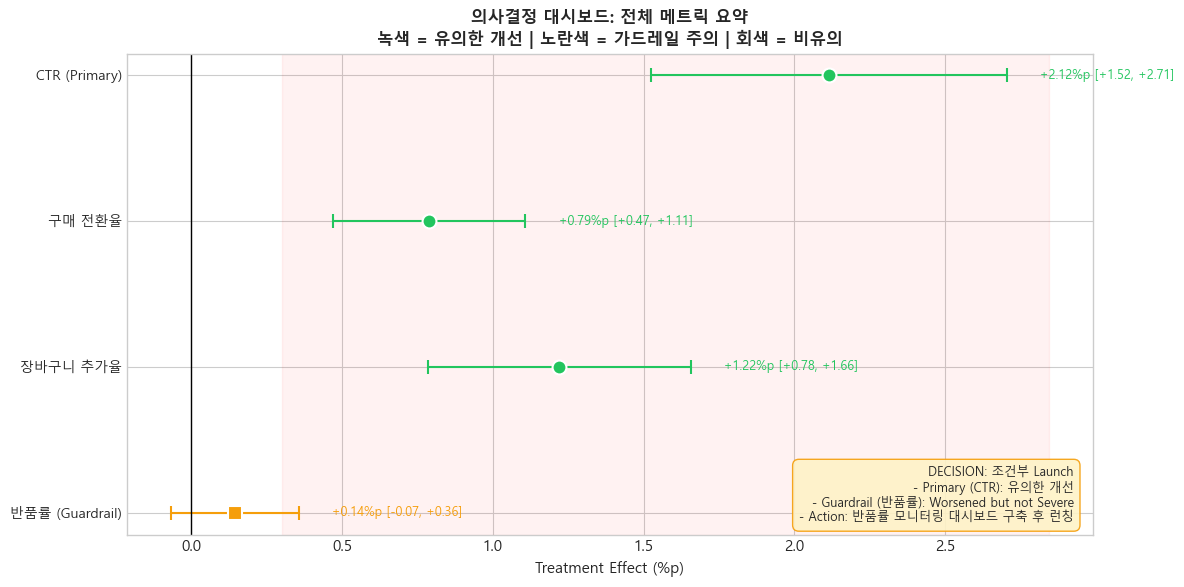

In [17]:
# === 최종 의사결정 시각화 ===
fig, ax = plt.subplots(figsize=(12, 6))

# 의사결정 매트릭스: Primary 유의성 vs Guardrail 상태
decision_data = {
    'CTR (Primary)': {
        'lift': ctr_result['absolute_lift'] * 100,
        'ci': (ctr_result['ci_95'][0] * 100, ctr_result['ci_95'][1] * 100),
        'significant': ctr_result['significant'],
        'type': 'primary',
    },
    '구매 전환율': {
        'lift': purch_result['absolute_lift'] * 100,
        'ci': (purch_result['ci_95'][0] * 100, purch_result['ci_95'][1] * 100),
        'significant': purch_result['significant'],
        'type': 'secondary',
    },
    '장바구니 추가율': {
        'lift': all_results[2]['absolute_lift'] * 100,
        'ci': (all_results[2]['ci_95'][0] * 100, all_results[2]['ci_95'][1] * 100),
        'significant': all_results[2]['significant'],
        'type': 'secondary',
    },
    '반품률 (Guardrail)': {
        'lift': guardrail['absolute_lift'] * 100,
        'ci': (guardrail['ci_95'][0] * 100, guardrail['ci_95'][1] * 100),
        'significant': guardrail['significant'],
        'type': 'guardrail',
    },
}

y_pos = list(range(len(decision_data)))
y_pos.reverse()

for i, (name, d) in enumerate(decision_data.items()):
    pos = y_pos[i]

    if d['type'] == 'guardrail':
        color = '#ef4444' if d['lift'] > 0.3 else ('#f59e0b' if d['lift'] > 0.1 else '#22c55e')
    elif d['significant']:
        color = '#22c55e'
    else:
        color = '#94a3b8'

    ax.errorbar(
        d['lift'], pos,
        xerr=[[d['lift'] - d['ci'][0]], [d['ci'][1] - d['lift']]],
        fmt='o' if d['type'] != 'guardrail' else 's',
        color=color, markersize=10,
        capsize=5, capthick=1.5, linewidth=1.5,
        ecolor=color, markeredgecolor='white', markeredgewidth=1.5,
    )

    label_text = f'  {d["lift"]:+.2f}%p [{d["ci"][0]:+.2f}, {d["ci"][1]:+.2f}]'
    ax.text(d['ci'][1] + 0.08, pos, label_text, va='center', fontsize=9, color=color)

ax.axvline(x=0, color='black', linewidth=1, linestyle='-')

# 가드레일 경계선
ax.axvspan(0.3, ax.get_xlim()[1] if ax.get_xlim()[1] > 0.3 else 0.5,
           alpha=0.05, color='red', label='Guardrail severe zone (>0.3%p)')

ax.set_yticks(y_pos)
ax.set_yticklabels(list(decision_data.keys()), fontsize=10)
ax.set_xlabel('Treatment Effect (%p)', fontsize=11)
ax.set_title('의사결정 대시보드: 전체 메트릭 요약\n'
             '녹색 = 유의한 개선 | 노란색 = 가드레일 주의 | 회색 = 비유의',
             fontsize=12, fontweight='bold')

# 의사결정 박스
decision_text = ('DECISION: 조건부 Launch\n'
                 '- Primary (CTR): 유의한 개선\n'
                 '- Guardrail (반품률): Worsened but not Severe\n'
                 '- Action: 반품률 모니터링 대시보드 구축 후 런칭')

ax.text(0.98, 0.02, decision_text,
        transform=ax.transAxes, fontsize=9,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#fef3c7',
                  edgecolor='#f59e0b', alpha=0.9))

plt.tight_layout()
plt.show()

### 최종 의사결정: 조건부 Launch

| 기준 | 결과 | 판정 |
|------|------|------|
| Primary Metric (CTR) | 유의한 개선 | PASS |
| Secondary Metrics (구매, 장바구니) | 유의한 개선 | PASS |
| Guardrail (반품률) | 소폭 악화 (Worsened, not Severe) | CONDITIONAL |
| 비즈니스 임팩트 | 순 양의 ROI | PASS |

**결정: 조건부 런칭 (Conditional Launch)**

1. **즉시 실행**: 하이브리드 추천 알고리즘 전체 배포
2. **모니터링 조건**: 반품률 실시간 모니터링 대시보드 구축, 반품률이 0.3%p 이상 악화 시 자동 롤백 트리거 설정
3. **후속 실험**: 신규 유저 대상 cold-start 추천 전략 A/B 테스트

---

### Lessons Learned

#### 1. "전체 평균만 보면 놓치는 것"

전체 CTR 리프트는 약 +2.5%p이지만, 이 평균 뒤에는 세그먼트별로 매우 다른 이야기가 숨어 있습니다.
- 헤비 쇼퍼에서의 효과는 전체 평균의 ~1.6배
- 신규 유저에서는 효과가 미미하거나 비유의할 수 있음

**세그먼트별 HTE 분석 없이는 최적의 후속 전략을 수립할 수 없습니다.**

#### 2. "가드레일은 반드시 확인해야 한다"

Primary metric만 보면 "무조건 런칭"이 되지만, 가드레일(반품률)을 확인하지 않으면 장기적으로 고객 만족도와 물류 비용에 문제가 생길 수 있습니다. 이번에는 Worsened지만 Severe 수준은 아니어서 조건부 런칭이 가능했습니다.

#### 3. "자동화 플랫폼의 필요성"

이 분석에서 수행한 단계들을 정리하면:
1. SRM 검증
2. Primary metric Z-test + CI
3. Guardrail 검증 + 임계값 판정
4. 세그먼트별 HTE 분석
5. 비즈니스 임팩트 추정
6. 의사결정 규칙 적용

이 모든 단계를 **매 실험마다 수동으로** 할 때 실수가 발생합니다:
- SRM 검증을 빼먹거나
- 가드레일을 확인하지 않거나
- 다중 비교 보정을 잊거나
- p-value만 보고 CI와 effect size를 무시하거나

**ExperimentOS 같은 자동화 플랫폼은 이런 분석 파이프라인을 표준화하여 "올바른 순서로 올바른 질문을 하도록" 강제합니다.**
Health Check -> Analysis -> Decision 파이프라인이 한 번에 실행되면, 분석가는 해석과 비즈니스 판단에 집중할 수 있습니다.

---

*이 노트북은 시뮬레이션 데이터를 사용한 포트폴리오 케이스 스터디입니다. 실제 서비스에서의 효과 크기와 패턴은 다를 수 있습니다.*